# LAB 5

The primary objective of this lab is to show how to use the
*rtweet* R package to collect data about tweets and Twitter 
users, and how to use the collected data to create graphs 
(social networks) of Twitter users in igraph.
The secondary objective is to demonstrate further the use 
of graph visualization R packages such as *visNetwork*.

### 1. SETUP

To be able to collect data from Twitter through the Twitter API
(https://developer.twitter.com/en/docs/twitter-api/v1)
you'll need to do the following things:

1) Set up a Twitter account, if you don’t already have one
(you do not need to be active on Twitter, just to have an account)

2) Install and load the following R packages: rtweet, httpuv, and tidyr

**rtweets** GitHub repository with lots of useful information on the front page:
https://github.com/ropensci/rtweet

In [1]:
# Install and load rtweet, httpuv, and tidyr R packages
# install.packages('rtweet')
# install.packages('httpuv')
# install.packages('tidyr')

In [2]:
library(rtweet)
library(httpuv)
library(tidyr)

We'll also install and load some additional 
R packages that we'll need for this lab:
- dplyr - for various data manipulation tasks (not specific to SNA)
- visNetwork - for creating interactive graph visualizations

In [3]:
# install.packages('visNetwork')
# install.packages('dplyr')
library(dplyr)
library(visNetwork)
library(igraph)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following object is masked from 'package:tidyr':

    crossing


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




### 2. SEARCH TWITTER AND COLLECT DATA FOR SETTING UP A NETWORK

In [ ]:
?search_tweets

In [19]:
tweets <- search_tweets(q = "#inaugurationday", type = 'recent',
                       lang="en", n = 15000, include_rts = FALSE, token = readRDS('rtweet_token.rds'))

Note: to more easily create complex queries, that is queries enabled by 
Twitter advanced search (https://twitter.com/search-advanced),
you can follow these guidelines:
https://help.twitter.com/en/using-twitter/twitter-advanced-search

In [20]:
# (optionally) save the results
# setwd("SNA_Labs")
saveRDS(tweets, 'data/inaugurationday_28-01-2021.RData')

In [21]:
# load the saved data (for offline work)
tweets <- readRDS("data/inaugurationday_28-01-2021.RData")

In [22]:
# Get a glimpse into the obtained dataset
glimpse(tweets)

Rows: 14,929
Columns: 90
$ user_id                 <chr> "2239829731", "2239829731", "2239829731", "...
$ status_id               <chr> "1354864322028167171", "1353472559786897412...
$ created_at              <dttm> 2021-01-28 18:50:01, 2021-01-24 22:39:39, ...
$ screen_name             <chr> "darkseidscouch", "darkseidscouch", "darkse...
$ text                    <chr> "https://t.co/X6XjGll8Kl Don't forget to su...
$ source                  <chr> "Twitter Web App", "Twitter Web App", "Twit...
$ display_text_width      <dbl> 273, 237, 259, 190, 223, 221, 256, 207, 231...
$ reply_to_status_id      <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ reply_to_user_id        <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ reply_to_screen_name    <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ is_quote                <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ is_retweet              <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ favorite_count          <

We will create "mention networks", that is networks with Twitter
users as nodes and connections (edges) established based on one
user mentioning another in his/her tweet. Mentioning can take the
form of direct replies or 'simple' mentions anywhere in the tweet's text.
So, we will have 2 networks: reply_to and mentioned networks. 

So, we will select only those columns (variables) that are relevant 
for creating "mention networks". We will also rename the selected 
columns, for the sake of having shorter variable names

In [23]:
tweets_users <- tweets %>%
  select(screen_name, reply_to_screen_name, mentions_screen_name) %>%
  rename(sender=screen_name, replied_to=reply_to_screen_name, mentioned=mentions_screen_name)

In [24]:
glimpse(tweets_users) 

Rows: 14,929
Columns: 3
$ sender     <chr> "darkseidscouch", "darkseidscouch", "darkseidscouch", "d...
$ replied_to <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ...
$ mentioned  <list> [NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA...


Note that the mentioned column is a list; we will deal with it later.

Note also that many entries have missing values (NA) for the 'replied_to' and 'mentioned'
variables. Check how many such cases we have:

In [25]:
sum(is.na(tweets_users$replied_to))

sum(is.na(tweets_users$mentioned))

[1] 12425

[1] 8512

Keep only those tweets where the sender mentioned or replied to at least 
one other Twitter user

In [26]:
tweets_users <- tweets_users %>%
  filter( (is.na(replied_to)==FALSE) | (is.na(mentioned)==FALSE) )

In [27]:
nrow(tweets_users)
#View(tweets_users[1:10,])
tweets_users[1:10,]

[1] 6695

sender        replied_to  
1  marymountu    NA          
2  marymountu    NA          
3  NatComm       NA          
4  NatComm       NA          
5  sharemylesson NA          
6  sharemylesson NA          
7  atouchofsnark KamalaHarris
8  atouchofsnark NA          
9  atouchofsnark NA          
10 63buglover    NA          
   mentioned                                                         
1  voguemagazine, MichelleObama                                      
2  MichelleObama                                                     
3  allisonprasch  , stephenhbrowne1, TheonHill      , MurphyOA       
4  UMD_COMM                                                          
5  AFTunion                                                          
6  DiscoveryEd, AFTunion                                             
7  KamalaHarris                                                      
8  JoeBiden    , KamalaHarris                                        
9  BidenInaugural, SAforBiden                                        
10 Sling

Next, we will unnest the 'mentioned' column. 
Unnesting is the transformation of a list-column, so that each 
element of the list gets its own row.

In [ ]:
?unnest

In [28]:
tweets_users <- unnest(tweets_users, mentioned) 
#View(tweets_users[1:20,])
tweets_users[1:20,]

sender         replied_to   mentioned      
1  marymountu     NA           voguemagazine  
2  marymountu     NA           MichelleObama  
3  marymountu     NA           MichelleObama  
4  NatComm        NA           allisonprasch  
5  NatComm        NA           stephenhbrowne1
6  NatComm        NA           TheonHill      
7  NatComm        NA           MurphyOA       
8  NatComm        NA           UMD_COMM       
9  sharemylesson  NA           AFTunion       
10 sharemylesson  NA           DiscoveryEd    
11 sharemylesson  NA           AFTunion       
12 atouchofsnark  KamalaHarris KamalaHarris   
13 atouchofsnark  NA           JoeBiden       
14 atouchofsnark  NA           KamalaHarris   
15 atouchofsnark  NA           BidenInaugural 
16 atouchofsnark  NA           SAforBiden     
17 63buglover     NA           Sling          
18 ThomBrowneNY   NA           katyperry      
19 ThomBrowneNY   NA           katyperry      
20 Oliver29239048 POTUS        POTUS

To create graphs, we need to transform our tweets_users data frame
into the format required by igraph's functions for graph construction.
In particular, we will transform it into 2 edge lists: one for the  
'reply_to' relation, and the other for the 'mentioned' relation.

First, create edge list for the 'reply_to' relation:

In [29]:
replied_to_edgelist <- tweets_users %>%
  select(-mentioned) %>%              # remove the 'mentioned' column
  filter(complete.cases(.)) %>%       # keep only complete rows, that is, rows without NAs
  group_by(sender, replied_to) %>%    # group the rows based on the sender, replied_to combination
  summarise(weight = n()) %>%         # compute the size of each group (i.e. number of connections 
  ungroup()                           # between each sender - replied_to pair) and assign it to the 
                                      # 'weight' variable

`summarise()` regrouping output by 'sender' (override with `.groups` argument)



In [30]:
head(replied_to_edgelist, n=10)

sender          replied_to      weight
1  _Babazile       ladygaga        1     
2  _itsKunalSingh  VP              4     
3  _itsMissFitz    CarolineHirons  1     
4  _JustMajesty    destinyschild   1     
5  _maghetweten    BernieSanders   1     
6  _MohdZaved      BidenInaugural  1     
7  _MrBugatti      IrshQtip        1     
8  _purposeproject TheAmandaGorman 1     
9  _racheldesigns_ _ashhlauren     1     
10 _racheldesigns_ Berrynelly      1

check the pairs with the most intensive communication: 

In [31]:
replied_to_edgelist %>%
  arrange(desc(weight)) %>%
  head(n=10)

sender          replied_to      weight
1  Katei2020       TheBushCenter   72    
2  midomashkal92   DASimmigration  66    
3  OhSoFrieda      OhSoFrieda      56    
4  midomashkal92   DV2021_         54    
5  AMPMTALK        ZACKHAMMER7     50    
6  Oliver29239048  POTUS           50    
7  RestlessNews    Robyn_CherCrew  50    
8  midomashkal92   AlaaElk40152086 39    
9  DV2021_         DASimmigration  37    
10 WaaambulanceNYC WaaambulanceNYC 36

In a similar way, create an edge list based on 'mentioned' relation

In [32]:
mentioned_edgelist <- tweets_users %>%
  select(-replied_to) %>%
  filter(complete.cases(.)) %>%
  group_by(sender, mentioned) %>%
  summarise(weight = n()) %>%
  ungroup()

`summarise()` regrouping output by 'sender' (override with `.groups` argument)



In [33]:
nrow(mentioned_edgelist)
head(mentioned_edgelist, n=10)

[1] 11100

sender          mentioned       weight
1  __Chimaera      ElieNYC         1     
2  __Chimaera      thenation       1     
3  __KAYEMARIE__   MichelleObama   1     
4  __wandererr     BernieSanders   1     
5  _AbstractRadio  JoeBiden        1     
6  _AmeliaJ        TheAmandaGorman 1     
7  _andreatoole    DouglasEmhoff   1     
8  _Annateur       BernieSanders   1     
9  _Annateur       SenSanders      1     
10 _Authentic_Self AROD            1

examine most frequent mentions:

In [34]:
mentioned_edgelist %>%
  arrange(desc(weight)) %>%
  head(n=10)

sender          mentioned    weight
1  midomashkal92   POTUS        122   
2  midomashkal92   ABlinken     120   
3  midomashkal92   VP           119   
4  midomashkal92   PressSec     116   
5  Koki3558        POTUS         72   
6  Koki3558        VP            70   
7  SafiKhanMagical KamalaHarris  67   
8  Oliver29239048  POTUS         61   
9  Oliver29239048  VP            56   
10 Koki3558        WhiteHouse    53

Get the unique users in each edge list.
Those will be nodes in the corresponding networks.

Unique users in replied_to edgelist

In [35]:
reply_to_unique <- union(replied_to_edgelist$sender, replied_to_edgelist$replied_to)


the number of unique users (nodes in the network)

In [36]:
length(reply_to_unique)

[1] 2659

Unique users in mentioned edgelist

In [37]:
mention_unique <- union(mentioned_edgelist$sender, mentioned_edgelist$mentioned)
length(mention_unique)

[1] 8901

Considering the large number of unique users, that is, the number of
nodes in the prospective networks, it is worth examining options for 
filtering out some of them, in order to:
- reduce the 'noise' in the data,
- make the graphs easier to manipulate and analyse.

To decide on how to do the filtering, we'll examine the frequency 
of connections


In [38]:
summary(replied_to_edgelist$weight)
summary(mentioned_edgelist$weight)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.183   3.000  72.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.343   1.000 122.000 

As there are too many users with loose connections 
(mentioned / replied_to just once),
keep only connections that are above the median
First for the mentioned edgelist:

In [39]:
mentioned_edgelist_reduced <- mentioned_edgelist %>%
  filter(weight > median(mentioned_edgelist$weight))

Note a huge reduction in the size of the edgelist

In [40]:
nrow(mentioned_edgelist_reduced)

[1] 992

Check again the number of unique users 

In [41]:
mention_unique <- union(mentioned_edgelist_reduced$sender, 
                         mentioned_edgelist_reduced$mentioned)

It is also significantly reduced

In [42]:
length(mention_unique)

[1] 763

Now, for the reply_to edge list:

In [43]:
replied_to_edgelist_reduced <- replied_to_edgelist %>%
  filter(weight > median(replied_to_edgelist$weight))

Again, a notable reduction

In [44]:
nrow(replied_to_edgelist_reduced)

[1] 645

Check again the number of unique users

In [45]:
reply_to_unique <- union(replied_to_edgelist_reduced$sender, 
                         replied_to_edgelist_reduced$replied_to)


It is reduced but not as much as in the case of the 
mentioned relation (as expected)

In [46]:
length(reply_to_unique)

[1] 787

Next, we'll collect users' data. These data can be used to describe nodes 
in networks, that is, to associate attributes to nodes.

First, we will collect data about the senders, since these data are available 
in the dataset we have already collected from Twitter (tweets data frame)


In [47]:
glimpse(tweets)

Rows: 14,929
Columns: 90
$ user_id                 <chr> "2239829731", "2239829731", "2239829731", "...
$ status_id               <chr> "1354864322028167171", "1353472559786897412...
$ created_at              <dttm> 2021-01-28 18:50:01, 2021-01-24 22:39:39, ...
$ screen_name             <chr> "darkseidscouch", "darkseidscouch", "darkse...
$ text                    <chr> "https://t.co/X6XjGll8Kl Don't forget to su...
$ source                  <chr> "Twitter Web App", "Twitter Web App", "Twit...
$ display_text_width      <dbl> 273, 237, 259, 190, 223, 221, 256, 207, 231...
$ reply_to_status_id      <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ reply_to_user_id        <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ reply_to_screen_name    <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ is_quote                <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ is_retweet              <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ favorite_count          <

Extract the data for all the senders, regardless of the type of relation
they established with alters (mentioned, replied_to). 

In [48]:
all_senders <- union(mentioned_edgelist_reduced$sender, 
                     replied_to_edgelist_reduced$sender)

senders_data <- tweets %>%
  filter(screen_name %in% all_senders) %>%  
  users_data() %>%                          # rtweet's function that pulls user data from a dataset of tweets
  distinct(user_id, .keep_all = TRUE)       # keep just distinct users (distinguish users based on user_id) 

check the kind of user data that is available

In [49]:
glimpse(senders_data)

Rows: 654
Columns: 20
$ user_id                <chr> "361280541", "472835083", "12704187495568097...
$ screen_name            <chr> "marymountu", "sharemylesson", "atouchofsnar...
$ name                   <chr> "Marymount University", "ShareMyLesson", "Gr...
$ location               <chr> "Arlington, VA", "Washington, DC", "https://...
$ description            <chr> "#LearnWithPurpose\n\nWe're a small school w...
$ url                    <chr> "http://t.co/S7IN4k6p2U", "https://t.co/023f...
$ protected              <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FA...
$ followers_count        <int> 4372, 13805, 1844, 33716, 210, 184, 3322, 84...
$ friends_count          <int> 200, 3642, 2385, 49, 493, 221, 2550, 1657, 2...
$ listed_count           <int> 77, 279, 16, 405, 0, 0, 3, 3469, 618, 0, 67,...
$ statuses_count         <int> 4887, 28268, 15344, 2614, 2362, 961, 8526, 6...
$ favourites_count       <int> 3144, 12140, 28, 3965, 3106, 1845, 31498, 13...
$ account_created_at     <dttm

Now, collect data for alters (mentioned / replied_to) - these are not necessarily
available in the collected tweets data, but have to be obtained separately.

First, identify the alters (users) for whom the data are not available

In [50]:
no_data_alters <- setdiff(union(mention_unique, reply_to_unique), all_senders)
length(no_data_alters)

[1] 609

Collect data for these users (no_data_alters) from Twitter. 
To that end, we will use the lookup_users function from rtweet package

In [ ]:
?lookup_users

In [51]:
alters_data <- lookup_users(no_data_alters, token = readRDS('rtweet_token.rds'))

save the data

In [52]:
saveRDS(alters_data, "data/raw_alters_data_28-01-2021.RData")

In [53]:
# load the saved data (for offline work)
alters_data <- readRDS("data/raw_alters_data_28-01-2021.RData")

In [54]:
glimpse(alters_data)

Rows: 601
Columns: 90
$ user_id                 <chr> "939091", "30354991", "26637348", "36488053...
$ status_id               <chr> "1354501085478625281", "1354501174133628928...
$ created_at              <dttm> 2021-01-27 18:46:38, 2021-01-27 18:46:59, ...
$ screen_name             <chr> "JoeBiden", "KamalaHarris", "TulsiGabbard",...
$ text                    <chr> "This afternoon, I’ll be taking action to m...
$ source                  <chr> "Twitter for iPhone", "Twitter for iPhone",...
$ display_text_width      <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ reply_to_status_id      <chr> NA, NA, "1354369574095917058", NA, "1354852...
$ reply_to_user_id        <chr> NA, NA, "26637348", NA, "117504544574529536...
$ reply_to_screen_name    <chr> NA, NA, "TulsiGabbard", NA, "Khadija_Dolans...
$ is_quote                <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ is_retweet              <lgl> TRUE, TRUE, FALSE, FALSE, FALSE, FALSE, FAL...
$ favorite_count          <int

In addition to user data, the lookup_users() f. also returned users' tweets.
However, we need only user data:

In [55]:
alters_data <- users_data(alters_data)

We should also check if we managed to retrieve data for all the users that 
we were interested in (the service may not return all the requested data)

In [56]:
missing_alter <- setdiff(no_data_alters, alters_data$screen_name)
length(missing_alter)

[1] 8

In case of missing user data, drop those users from the edge lists 
before saving those edge lists to files (see below).

Since we have done a lot of relevant processing steps, it would be wise to save 
the created edge lists and user attributes, so that we do not have to repeat the
processing steps.
Before saving edge lists, rename columns to the typical names used in edge lists

In [57]:
mentioned_edgelist_reduced %>%
  filter(!mentioned %in% missing_alter) %>%
  rename(ego=sender, alter=mentioned, mention_tie=weight) %>%
  saveRDS(file = "data/mentions_edgelist_28-01-2020.RData")

In [58]:
replied_to_edgelist_reduced %>%
  filter(!replied_to %in% missing_alter) %>%
  rename(ego=sender, alter=replied_to, reply_to_tie=weight) %>%
  saveRDS(file = "data/replied_to_edgelist_28-01-2020.RData")

Merge all available user data and store it in a file

In [59]:
senders_data %>%
  rbind(alters_data) %>%
  saveRDS("data/user_data_28-01-2020.RData")

Do the clean up, that is, remove all objects from the environment, 
we won't need them any more

In [60]:
remove(list = ls())

### 3. CREATE NETWORKS OF TWITTER USERS

Load data (edge list) for creating a network based on the 'mentioned' relation

In [61]:
mention_edgelist <- readRDS("data/mentions_edgelist_28-01-2020.RData")
glimpse(mention_edgelist)

Rows: 987
Columns: 3
$ ego         <chr> "_itsKunalSingh", "_itsKunalSingh", "_itsKunalSingh", "...
$ alter       <chr> "JoeBiden", "KamalaHarris", "TulsiGabbard", "BrandonJoD...
$ mention_tie <int> 2, 2, 2, 2, 3, 2, 6, 6, 7, 7, 8, 2, 3, 3, 3, 2, 2, 2, 3...


Create a directed network

In [62]:
mention_net <- graph_from_data_frame(mention_edgelist)
summary(mention_net)

IGRAPH 196b80d DN-- 755 987 -- 
+ attr: name (v/c), mention_tie (e/n)


Obviously very sparse network; let's check its density

In [63]:
edge_density(mention_net)

[1] 0.001733799

We can try to plot the graph, but it is overly large 
and the plot will be messy

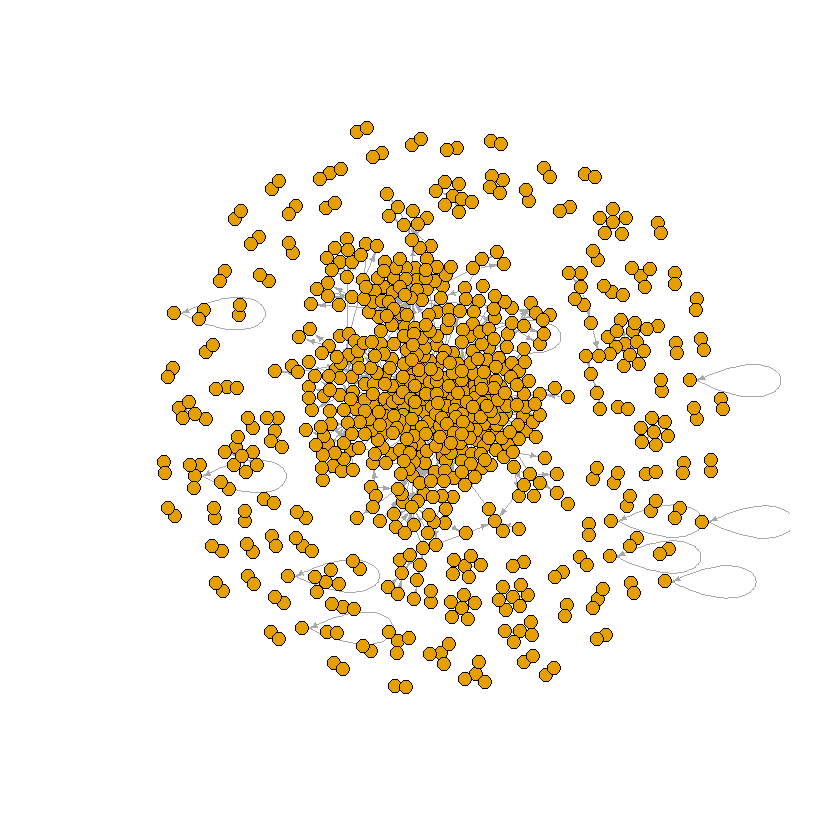

In [64]:
plot(mention_net, 
     layout = layout_with_graphopt(mention_net),
     edge.arrow.size=0.3,
     vertex.size = 5,
     vertex.label = NA)

We will get back to the plotting task a bit later.

Let's add attributes to nodes, and use these to better understand the network.
For example, we can include the number of followers, friends, and tweets.
To that end, we will create a function that receives: 

1) Twitter user data as returned by the rtweet's users_data() function, 

2) a vector of screen names of those users we are interested in.

The function returns a data frame with four variables (columns):
screen_name, followers_count, friends_count, and statuses_count

In [65]:
get_user_attrs <- function(twitter_user_data, users_screen_names) {
  twitter_user_data %>%
    filter(screen_name %in% users_screen_names) %>%
    select(screen_name, followers_count, friends_count, statuses_count)
}

Load user data; it will be used to add attributes to the nodes

In [66]:
user_data <- readRDS("data/user_data_28-01-2020.RData")

Extract the set of attributes we are interested in 

In [67]:
ego_attrs <- get_user_attrs(user_data, V(mention_net)$name)
glimpse(ego_attrs)

Rows: 755
Columns: 4
$ screen_name     <chr> "marymountu", "sharemylesson", "atouchofsnark", "Th...
$ followers_count <int> 4372, 13805, 1844, 33716, 210, 3322, 845556, 1814, ...
$ friends_count   <int> 200, 3642, 2385, 49, 493, 2550, 1657, 285, 477, 122...
$ statuses_count  <int> 4887, 28268, 15344, 2614, 2362, 8526, 69118, 32919,...


Extract attributes about users mentioned in tweets (alters)

In [68]:
alter_attrs <- get_user_attrs(user_data, V(mention_net)$name)  
glimpse(alter_attrs)

Rows: 755
Columns: 4
$ screen_name     <chr> "marymountu", "sharemylesson", "atouchofsnark", "Th...
$ followers_count <int> 4372, 13805, 1844, 33716, 210, 3322, 845556, 1814, ...
$ friends_count   <int> 200, 3642, 2385, 49, 493, 2550, 1657, 285, 477, 122...
$ statuses_count  <int> 4887, 28268, 15344, 2614, 2362, 8526, 69118, 32919,...


Merge attributes for all the actors in the 'mentioned' network 

In [69]:
node_attrs <- rbind(ego_attrs, alter_attrs) %>% # merge the two data frames
  distinct(screen_name, .keep_all = TRUE) %>%   # keep only distinct rows (= remove duplicates)
  arrange(screen_name)                          # sort based on the username

In [70]:
head(node_attrs, n=10)
summary(node_attrs[,-1])

screen_name     followers_count friends_count statuses_count
1  _Hybreed_       458038          163787        118767        
2  _itsKunalSingh     241             231         19821        
3  1stForAll        57680            2009         30314        
4  1TRUE_AMERICA       65             243          5493        
5  2021Winer          224             417          1818        
6  27cc40a7ee3a402    463            1310         33568        
7  30seconds        28972            6266        210399        
8  6_rabbits          475             821          1594        
9  7NewsAustralia  185644             186        175666        
10 7NewsSydney     342445             179        254964

 followers_count     friends_count    statuses_count  
 Min.   :        0   Min.   :     0   Min.   :     0  
 1st Qu.:      264   1st Qu.:   192   1st Qu.:  1876  
 Median :     2830   Median :   763   Median :  9615  
 Mean   :  1678588   Mean   :  3445   Mean   : 42141  
 3rd Qu.:   120103   3rd Qu.:  2148   3rd Qu.: 37567  
 Max.   :109279317   Max.   :215077   Max.   :947554  

Create graph with node attributes

In [71]:
mention_net <- graph_from_data_frame(mention_edgelist, 
                                     vertices = node_attrs)
summary(mention_net)
summary(V(mention_net)$followers_count)

IGRAPH 31e0568 DN-- 755 987 -- 
+ attr: name (v/c), followers_count (v/n), friends_count (v/n),
| statuses_count (v/n), mention_tie (e/n)


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
        0       264      2830   1678588    120103 109279317 

Let's now make use of the vertex attributes to better understand the graph.

We'll make the size of the nodes proportional to the number of followers and 
use color to reflect the number of posted tweets (statuses) 
Create gradient color vector based on the number of friends:

In [72]:
source('SNA_custom_functions.R')
posts_for_color <- attr_based_color_gradient(log1p(V(mention_net)$statuses_count), 
                                               c('grey100','midnightblue'))

Create a vector for node sizes, based on the number of followers

In [73]:
followers_for_size <- log1p(V(mention_net)$followers_count)

Note that we've used logged values of both the friend_count and followers_count 
vectors due to the very uneven distribution of values of these two attributes 
(plot the density functions of these attributes to see the distribution)

Now, draw a plot

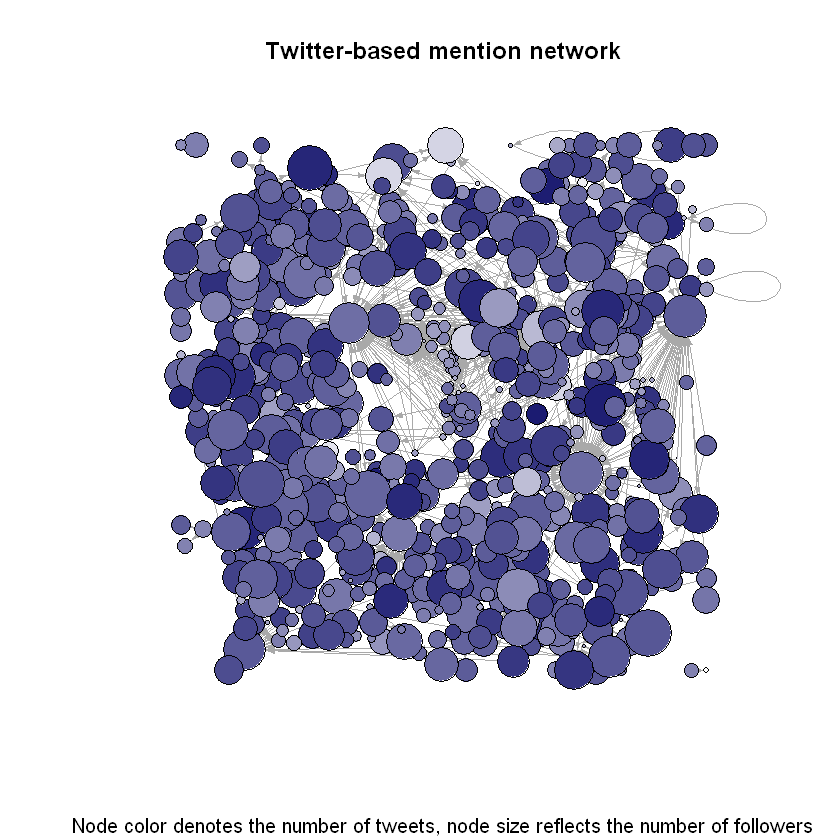

In [74]:
plot(mention_net, 
     layout = layout_with_dh(mention_net),
     edge.arrow.size=0.3, 
     vertex.label = NA,
     vertex.size = followers_for_size,
     vertex.color = posts_for_color,
     main = "Twitter-based mention network",
     sub= "Node color denotes the number of tweets, node size reflects the number of followers")

#### TASK: 
Follow the above procedure to create and visualise a graph based on the reply_to connection

### 4. VISUALISE NETWORKS OF TWITTER USERS USING VISNETWORK

Since the overall graph is overly large for meaningful visualization
let's take its giant component and create its visualization.

We will start by identifying components (subgraphs) in the graph. 
Due to the sparsity of edges, we won't be able to identify 'strong' components, 
so, we will opt for 'weak' components (reminder: for 'strong' components, the 
directionality of edges is considered; for detection of 'weak' components, the 
direction of edges is disregarded)

In [75]:
m_net_comp <- components(mention_net, mode = 'weak')
str(m_net_comp)

List of 3
 $ membership: Named num [1:755] 1 2 2 3 2 2 2 2 2 2 ...
  ..- attr(*, "names")= chr [1:755] "_Hybreed_" "_itsKunalSingh" "1stForAll" "1TRUE_AMERICA" ...
 $ csize     : num [1:111] 7 466 8 4 2 5 3 2 3 3 ...
 $ no        : int 111


Identify the largest (gigantic) component:

In [76]:
giant_comp_size <- max(m_net_comp$csize)
giant_comp_index <- which(m_net_comp$csize == giant_comp_size)

Get ids of nodes that belong to the gigantic component:

In [77]:
nodes_in_gc <- which(m_net_comp$membership==giant_comp_index)

Next, extract the giant component from the mention_net graph. 
To that end, we will use induced_subgraph function

In [ ]:
?induced_subgraph

In [78]:
giant_comp <- induced_subgraph(mention_net, vids = nodes_in_gc)

In [79]:
summary(giant_comp)
is_connected(giant_comp, mode = 'weak')

IGRAPH 684b8ee DN-- 466 798 -- 
+ attr: name (v/c), followers_count (v/n), friends_count (v/n),
| statuses_count (v/n), mention_tie (e/n)


[1] TRUE

Now, plot the giant component using igraph's plotting features. 
Use the same kind of mapping between nodes' attributes 
(statuses_count and followers_count) and their visual representation 
(color and size, respectively)

In [80]:
gc_colors <- attr_based_color_gradient(log1p(V(giant_comp)$statuses_count), 
                                       c('grey100','midnightblue'))

In [81]:
gc_size <- log1p(V(giant_comp)$followers_count)

In [82]:
set.seed(2501)

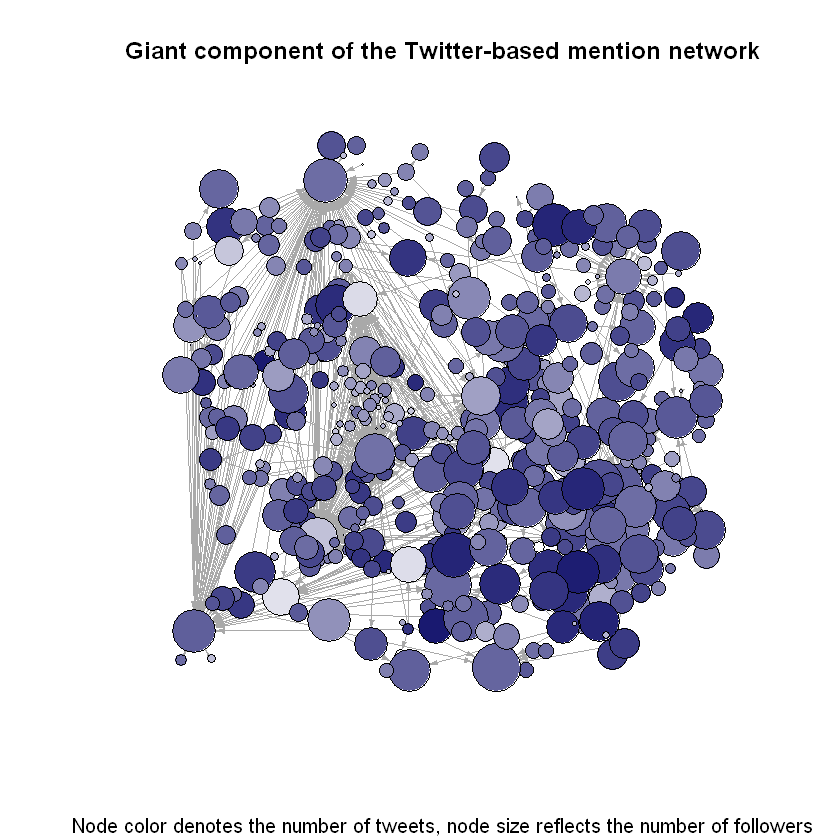

In [83]:
plot(giant_comp, 
     layout = layout_with_dh(giant_comp),
     edge.arrow.size=0.3, 
     vertex.label = NA,
     vertex.size = gc_size,
     vertex.color = gc_colors,
     main = "Giant component of the Twitter-based mention network",
     sub="Node color denotes the number of tweets, node size reflects the number of followers")

Better than the previous graph, but still not sufficiently clear. 
To try to get a better insight into the network, we will use interactive plots of the
*visNetwork* R package.

Note: for a tutorial on visNetwork and examples of use, see:
- Introduction to visNetwork, at:
  https://cran.r-project.org/web/packages/visNetwork/vignettes/Introduction-to-visNetwork.html 
- visNetwork documentation:
  http://datastorm-open.github.io/visNetwork/ 
- Section 6.2 of the 'Network visualization with R' tutorial, available at:
  http://kateto.net/network-visualization

As a minimum for graph visualization, visNetwork requires:
- nodes data frame, with 'id' column (plus any additional columns with node attributes)
- edges data.frame, with 'from' and 'to' columns (plus any additional columns with edge attributes)


Let's create those two (minimal) data frames:

In [84]:
nodes_df <- data.frame(id=V(giant_comp)$name, stringsAsFactors = FALSE)
head(nodes_df)

id             
1 _itsKunalSingh 
2 1stForAll      
3 2021Winer      
4 27cc40a7ee3a402
5 30seconds      
6 6_rabbits

In [85]:
edges_df <- data.frame(as_edgelist(giant_comp), stringsAsFactors = FALSE)
colnames(edges_df) <- c('from', 'to')
head(edges_df)

from           to            
1 _itsKunalSingh JoeBiden      
2 _itsKunalSingh KamalaHarris  
3 _itsKunalSingh TulsiGabbard  
4 1stForAll      BrandonJoDixon
5 1stForAll      JoeBiden      
6 2021Winer      ABlinken

Now, we can create the simplest visualisation with visNetwork

In [86]:
visNetwork(nodes = nodes_df, 
           edges = edges_df, 
           main="Giant component of the Twitter mention network")

HTML widgets cannot be represented in plain text (need html)

Extend the nodes data frame with columns defining node color and size
Note: see visNodes for column naming rules

In [87]:
nodes_df$color <- gc_colors
nodes_df$size <- gc_size * 2
head(nodes_df)

id              color   size    
1 _itsKunalSingh  #5B5B99 10.97788
2 1stForAll       #535394 21.92537
3 2021Winer       #8686B3 10.83220
4 27cc40a7ee3a402 #515193 12.27977
5 30seconds       #31317F 20.54824
6 6_rabbits       #8888B5 12.33084

Extend the edges data frame with columns defining edge width, color, 
if it is curvy or not, and if / how arrows are displayed.
Note: see visEdges for column naming and available options

In [88]:
edges_df$width <- 1 + (E(giant_comp)$mention_tie / 2)
edges_df$color <- 'slategray3'
edges_df$smooth <- TRUE # should the edges be curved?
edges_df$arrows <- 'to'
head(edges_df)

from           to             width color      smooth arrows
1 _itsKunalSingh JoeBiden       2.0   slategray3 TRUE   to    
2 _itsKunalSingh KamalaHarris   2.0   slategray3 TRUE   to    
3 _itsKunalSingh TulsiGabbard   2.0   slategray3 TRUE   to    
4 1stForAll      BrandonJoDixon 2.0   slategray3 TRUE   to    
5 1stForAll      JoeBiden       2.5   slategray3 TRUE   to    
6 2021Winer      ABlinken       4.0   slategray3 TRUE   to

In [89]:
visNetwork(nodes = nodes_df, 
           edges = edges_df, 
           main="Giant component of the Twitter mention network",
           footer = "Node color denotes the number of tweets, node size reflects the number of followers")

HTML widgets cannot be represented in plain text (need html)

Let's add a few additional details for node display:

In [90]:
nodes_df$title  <- nodes_df$id  # text to be displayed on mouse over 
nodes_df$borderWidth <- 1.5     # node border width

Instead of one color for a node, we can specify different colors 
for different parts of a node (main body and border) and different interaction states.
First, remove the existing coor attribute

In [91]:
nodes_df <- nodes_df %>% select(-color)

Then, add new color-related attributes

In [92]:
nodes_df$color.background <- gc_colors
nodes_df$color.border <- "black"
nodes_df$color.highlight.background <- "orange" # color of the main body of a node when clicked
nodes_df$color.highlight.border <- "darkred"    # color of the border when a node is clicked

Run the visualization with the new parameters set

In [93]:
visnet <- visNetwork(nodes = nodes_df, 
                     edges = edges_df, 
                     main="Giant component of the Twitter-based mention network",
                     footer = "Node color denotes the number of tweets, 
                                node size reflects the number of followers")
visnet

HTML widgets cannot be represented in plain text (need html)

In [ ]:
# To see the various node attributes that can be used, check:
?visNodes

In [ ]:
# Similarly, for the recognised edge-related attributes, see
?visEdges

visNetwork offers a number of other options available through 
the visOptions() function. For instance, we can highlight all 
direct neighbors and those 2 hops away:

In [94]:
visnet2 <- visOptions(visnet, 
                      highlightNearest = list(enabled = TRUE, degree = 2))
visnet2

HTML widgets cannot be represented in plain text (need html)

In [ ]:
# explore other visOptions
?visOptions

In [ ]:
# To examine the available layout options
?visLayout

In [95]:
visLayout(visnet, randomSeed = 2021, improvedLayout = TRUE)

HTML widgets cannot be represented in plain text (need html)

#### TASK: 
Follow the above procedure to create and visualise - using visNetwork - giant component of the graph based on the reply_to connection